In [1]:
import numpy as np
import cellbox
import json
import pickle

2023-08-23 21:03:57.178279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 21:03:57.351955: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 21:03:57.356497: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/lsf10/10.1/linux3.10-glibc2.17-x86_64/lib:/data/weirauchlab/opt/lib

Instructions for updating:
non-resource variables are not supported in the long term
   _____     _ _ ____              
  / ____|   | | |  _ \             
 | |     ___| | | |_) | _____  __  
 | |    / _ \ | |  _ < / _ \ \/ /  
 | |___|  __/ | | |_) | (_) >  <   
  \_____\___|_|_|____/ \___/_/\_\  
Running CellBox scripts developed in Sander lab
Maintained by Bo Yuan, Judy Shen, and Augustin Luna; contributions by Daniel Ritter

        version 0.3.2
        -- Feb 10, 2023 --
        * Modify CellBox to support TF2     
        
Tutorials and documentations are available at https://github.com/sanderlab/CellBox
If you want to discuss the usage or to report a bug, please use the 'Issues' function at GitHub.
If you find CellBox useful for your research, please consider citing the corresponding publication.
For more information, please email us at boyuan@g.harvard.edu and c_shen@g.harvard.edu, augustin_luna@hms.harvard.edu
 ----------------------------------------------------------------

Things to think about when making test cases for these:
* Seed
* Data partition method (do 3 things: RP, LOO, S2C). Drug index param
* ODE options (tanh, polynomial, heun, euler)
* Initialize similar weights

In [4]:
with open("/users/ngun7t/Documents/cellbox-jun-6/configs_dev/test_cases/Case_1.json", "r") as f:
    base_case = json.load(f)

In [7]:
seeds = np.random.randint(0, 1000, size=(5))
seeds

array([853, 748,  78, 233, 648])

In [17]:
seeds = [853, 748,  78, 233, 648]
drug_indices = [5, 10, 2, 8, 9]
data_partitions = [
    "random partition",
    "random partition with replicates",
    "single to combo",
    "leave one out (w/o single)",
    "leave one out (w/ single)"
]
# ode params: envelope_fn, ode_solver, polynomial_k 
# fixed ode params: dT = 0.1, ode_degree = 1, envelop = 0, 
odes = [
    ("tanh", "heun", 0),
    ("polynomial", "euler", 0),
    ("clip linear", "midpoint", 0),
    ("polynomial", "heun", 2),
    ("hill", "rk4", 2)
]

base = {
  "experiment_id": "Test_cases_torch",
  "experiment_type": "random partition",
  "model": "CellBox",
  "sparse_data": False,
  "pert_file": "/users/ngun7t/Documents/cellbox-jun-6/data/pert.csv",
  "expr_file": "/users/ngun7t/Documents/cellbox-jun-6/data/expr.csv",
  "node_index_file": "/users/ngun7t/Documents/cellbox-jun-6/data/node_Index.csv",
  "n_protein_nodes": 82,
  "n_activity_nodes": 87,
  "n_x" : 99,
  "trainset_ratio": 0.7,
  "validset_ratio": 0.8,
  "batchsize": 4,
  "add_noise_level": 0,

  "envelop_form": "tanh",
  "dT": 0.1,
  "envelop":0,
  "ode_degree": 1,
  "ode_solver": "heun",
  "ode_last_steps": 2,
  "l1lambda": 1e-4,
  "l2lambda": 1e-4,

  "n_epoch": 10000,
  "n_iter": 10000,
  "n_iter_buffer":50,
  "n_iter_patience":100,

  "stages":[{
    "nT": 100,
    "sub_stages":[
        {"lr_val": 0.1,"l1lambda": 0.01, "n_iter_patience":1000},
        {"lr_val": 0.01,"l1lambda": 0.01},
    ]}],

    "export_verbose": 3,
    "ckpt_name": "model11.pth"
}


### Initialize weights

In [3]:
def weight_init(seed, n_x=99, n_protein_nodes=82, n_activity_nodes=87):
    np.random.seed(seed)
    W = np.random.normal(0.01, 1.0, size=(n_x, n_x))
    W_mask = (1.0 - np.diag(np.ones([n_x])))
    W_mask[n_activity_nodes:, :] = np.zeros([n_x - n_activity_nodes, n_x])
    W_mask[:, n_protein_nodes:n_activity_nodes] = np.zeros([n_x, n_activity_nodes - n_protein_nodes])
    W_mask[n_protein_nodes:n_activity_nodes, n_activity_nodes:] = np.zeros([n_activity_nodes - n_protein_nodes,
                                                                            n_x - n_activity_nodes])

    return W*W_mask

In [14]:
for i, seed in enumerate(seeds):
    np.random.seed(seed)
    W = np.random.normal(0.01, 1.0, size=(99, 99))
    #W = weight_init(seed)
    with open(f"/users/ngun7t/Documents/cellbox-jun-6/test_arrays/full_training/full-training_weights_00{i}.npy", "wb") as f:
        np.save(f, W)

### Make the training config files, first make it for Tensorflow then manually change it for pytorch

In [18]:
import copy

for i, seed in enumerate(seeds):
    drug_index = drug_indices[i]
    data_partition = data_partitions[i]
    ode = odes[i]

    #envelope_fn, ode_solver, polynomial_k 
    param = {
        "working_index": drug_index,
        "seed": seed,
        "experiment_type": data_partition,
        "envelop_form": ode[0],
        "ode_solver": ode[1],
        "polynomial_k": ode[2]
    }
    new_case = copy.deepcopy(base)
    new_case.update(param)
    print(type(new_case))
    with open(f"/users/ngun7t/Documents/cellbox-jun-6/test_arrays/full_training/full-training_torch-config_00{i}.json", "w") as f:
        json.dump(new_case, f)

<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>
<class 'dict'>


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [26]:
tf_df = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Test_cases_37ad7a53ebd1d88392fb1cbfcc5f6722/seed_748/2_best.y_hat.loss.0.15325296476483344.csv"
torch_df = "/data/weirauchlab/team/ngun7t/cellbox_results/results/Test_cases_torch_044d0718503cf2355b5f625b0544ecc3/seed_748/2_best.y_hat.loss.0.18864094644784926.csv"

tf_np = pd.read_csv(tf_df).to_numpy()
torch_np = pd.read_csv(torch_df).to_numpy()

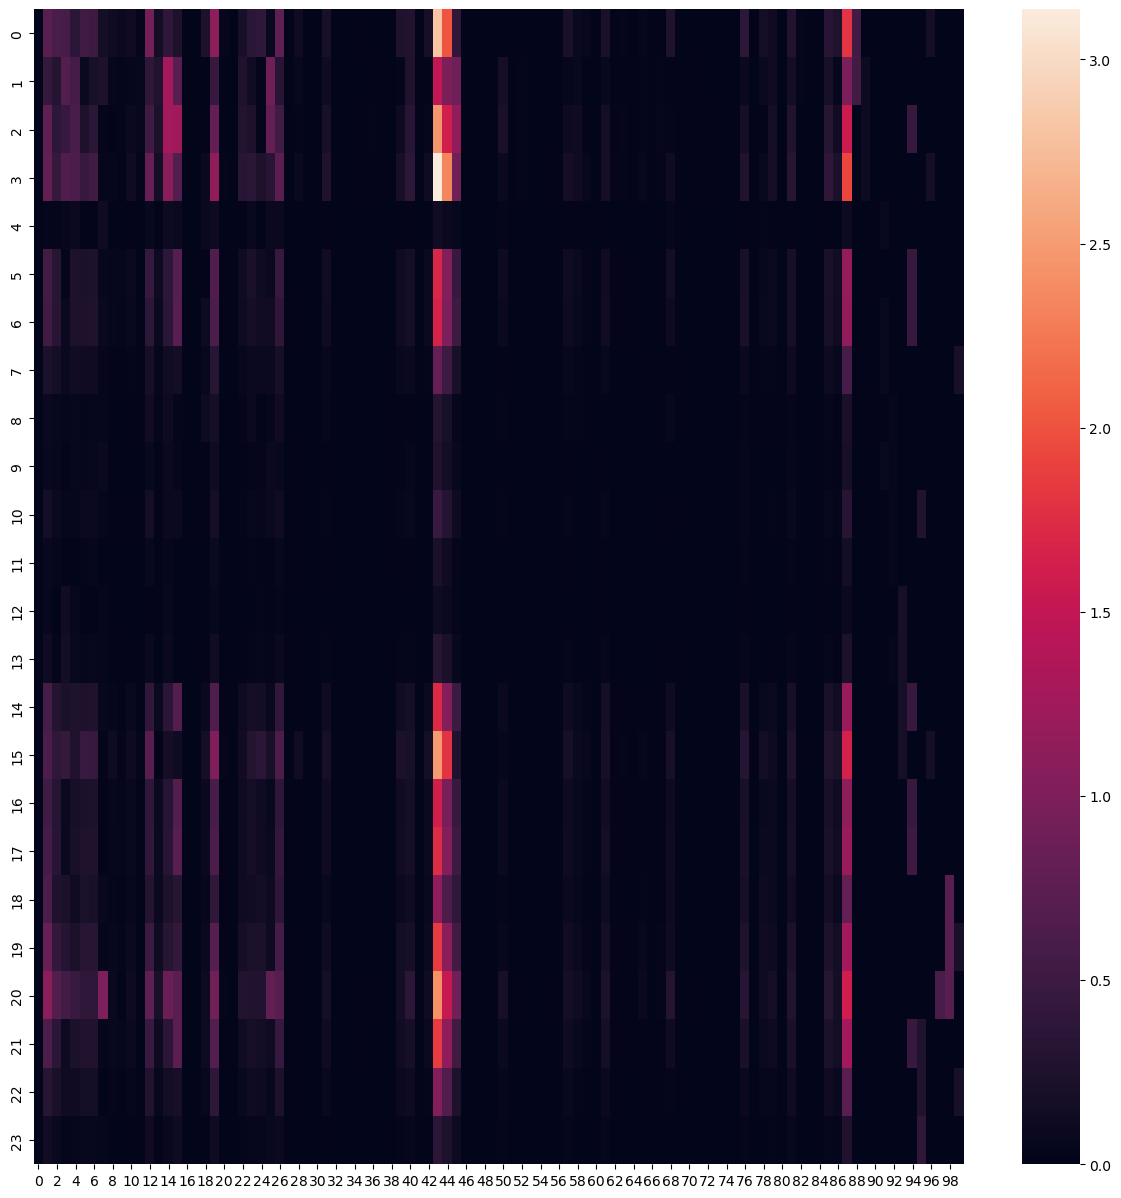

In [27]:
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(tf_np - torch_np))
plt.show()